In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
import eli5

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from eli5.sklearn import PermutationImportance


In [67]:
test = pd.read_csv('./test.csv')
train = pd.read_csv('./train.csv')


In [68]:
train.info(verbose = True)
test.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  

In [69]:
train['set'] = 1
test['set'] = 0
train_test=train.append(other = test)
train_test.reset_index(drop = False, inplace = True)

In [90]:
train_test.isnull().sum()


AttributeError: 'numpy.ndarray' object has no attribute 'isnull'

In [71]:

# Dealing with missing value in CryoSleep with billing feature vice versa
non_sleeping_features = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
train_test.loc[:,non_sleeping_features]=train_test.apply(lambda x: 0 if x.CryoSleep == True else x,axis =1)
train_test['Expenses'] = train_test.loc[:,non_sleeping_features].sum(axis=1)
train_test.loc[:,['CryoSleep']]=train_test.apply(lambda x: True if x.Expenses == 0 and pd.isna(x.CryoSleep) else x,axis =1)
train_test.loc[:,['CryoSleep']]=train_test.apply(lambda x: False if x.Expenses != 0 and pd.isna(x.CryoSleep) else x,axis =1)

In [72]:
train_test.loc[:,['FirstName']] = train_test.Name.str.split(" ",expand=True).iloc[:,0]
train_test.loc[:,['LastName']] = train_test.Name.str.split(" ",expand=True).iloc[:,1]

In [73]:
# Generate new feature from existing features
train_test.loc[:,['group']] = train_test.PassengerId.apply(lambda x: x[0:4] ).astype('int')
train_test.loc[:,['id']] = train_test.PassengerId.apply(lambda x: x.split("_")[1]).astype('int')

train_test['group_size']=train_test['group'].map(lambda x: train_test['group'].value_counts()[x])
train_test["Financial"] = train_test["Expenses"].apply(lambda x: "poor" if x < 1500 else ("middle" if x>5000 and x<12000 else ("no_expense" if x == 0 else "rich")))

In [74]:
# cols = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck', 'Expenses']

# for col in cols:
#     train_test.loc[train_test[col]==0, col] = 0.367
#     train_test[col] = np.log(train_test[col])

In [75]:
def add_traveller_type(df):

    checkdict ={

    }
    newColumnTravellerType = []

    for index in range(len(df)):
        gggg =df.iloc[index]['PassengerId'].split('_')[0]
        if df.iloc[index]['Name'] != df.iloc[index]['Name'] :
            lastname = 'NA'
        else :
            lastname =df.iloc[index]['Name'].split(' ')[1]
        if gggg in checkdict:
            checkdict[gggg].append(lastname)
        else :
            checkdict[gggg] = [lastname]

    for index in range(len(df)):
        gggg =df.iloc[index]['PassengerId'].split('_')[0]
        lastnames = checkdict[gggg]
        lastname = 'NA'
        if df.iloc[index]['Name'] == df.iloc[index]['Name'] :
            lastname =df.iloc[index]['Name'].split(' ')[1]

        if len(lastnames) == 1:
            newColumnTravellerType.append('INDIVIDUAL')
        elif len(lastnames) > 1:
            if lastname != 'NA' and lastnames.count(lastname) > 1:
                newColumnTravellerType.append('FAMILY')
            else :
                newColumnTravellerType.append('GROUP')

    df['TravellerType'] = newColumnTravellerType
    return df

train_test=  add_traveller_type(train_test)

In [76]:
# From inspecting impact of same group's member, we can found out that same group's members come from 
# same planet and has high probability is from same family (i.e same last name), same cabin

group_Cabin     = train_test.loc[:,['group','Cabin']].dropna().drop_duplicates('group')
group_LastName = train_test.loc[:,['group','LastName']].dropna().drop_duplicates('group')
group_HomePlanet  = train_test.loc[:,['group','HomePlanet']].dropna().drop_duplicates('group')
train_test      = pd.merge(train_test,group_Cabin,how="left",on='group',suffixes=('','_y'))
train_test      = pd.merge(train_test,group_LastName,how="left",on='group',suffixes=('','_y'))
train_test      = pd.merge(train_test,group_HomePlanet,how="left",on='group',suffixes=('','_y'))

# Fill in the missing value related to group
#train_test.loc[:,['Cabin']]=train_test.apply(lambda x:  x.Cabin_y if pd.isna(x.Cabin) else x,axis=1)
train_test.loc[:,['HomePlanet']]=train_test.apply(lambda x:  x.HomePlanet_y if pd.isna(x.HomePlanet) else x,axis=1)
train_test.loc[:,['LastName']]=train_test.apply(lambda x:  x.LastName_y if pd.isna(x.LastName) else x,axis=1)

In [77]:

train_test.loc[:,['Cabin_deck']] = train_test.Cabin.str.split("/",expand=True).iloc[:,0]
train_test.loc[:,['Cabin_num']] = train_test.Cabin.str.split("/",expand=True).iloc[:,1]
train_test.loc[:,['Cabin_side']] = train_test.Cabin.str.split("/",expand=True).iloc[:,2]

train_test['Cabin_num' ].fillna(value = -1, inplace = True)
train_test['Cabin_num'] = train_test['Cabin_num'].astype(dtype = 'int')


In [78]:
def cabin_regions(df):
    df["Cabin_Region1"] = (df["Cabin_num"]<300)
    df["Cabin_Region2"] = (df["Cabin_num"]>=300) & (df["Cabin_num"]<600)
    df["Cabin_Region3"] = (df["Cabin_num"]>=600) & (df["Cabin_num"]<900)
    df["Cabin_Region4"] = (df["Cabin_num"]>=900) & (df["Cabin_num"]<1200)
    df["Cabin_Region5"] = (df["Cabin_num"]>=1200) & (df["Cabin_num"]<1500)
    df["Cabin_Region6"] = (df["Cabin_num"]>=1500)

    return df

train_test = cabin_regions(train_test)

train_test['Age_group'] = 0
train_test.loc[train_test['Age']  == 0, 'Age_group'] = 1
train_test.loc[(train_test['Age'] > 0) & (train_test['Age'] <= 10), 'Age_group']=2
train_test.loc[(train_test['Age'] > 10) & (train_test['Age'] <= 20), 'Age_group']=3
train_test.loc[(train_test['Age'] > 20) & (train_test['Age'] <= 30), 'Age_group']=4
train_test.loc[(train_test['Age'] > 30) & (train_test['Age'] <= 50), 'Age_group']=5
train_test.loc[(train_test['Age'] > 50) & (train_test['Age'] <= 60), 'Age_group']=6
train_test.loc[(train_test['Age'] > 60) & (train_test['Age'] <= 70), 'Age_group']=7
train_test.loc[train_test['Age']  > 70, 'Age_group'] = 8


In [79]:
df = train_test.sort_values('group')
df.to_csv('group_inspect.csv', index=False)

In [80]:
num_cols = ['ShoppingMall','FoodCourt','RoomService','Spa','VRDeck','Expenses']
cat_cols = ['CryoSleep','Cabin_deck', 'Cabin_side','VIP','HomePlanet','Destination', 'TravellerType',
             'Financial', 'Cabin_Region1', 'Cabin_Region2', 'Cabin_Region3', 'Cabin_Region4', 'Cabin_Region5',
              'Cabin_Region6', 'Age_group', 'group_size']
transported=['Transported']
train_test_1 = train_test[num_cols+cat_cols+transported+['set', 'Age','Cabin_num']].copy()

num_imp = SimpleImputer(strategy='median')
cat_imp = SimpleImputer(strategy='most_frequent')
ohe = OneHotEncoder (handle_unknown='ignore',sparse = False)
le = LabelEncoder()

# Filling other missing value unrelated to group
train_test[num_cols] = pd.DataFrame(num_imp.fit_transform(train_test_1[num_cols]),columns=num_cols)
train_test[cat_cols] = pd.DataFrame(cat_imp.fit_transform(train_test_1[cat_cols]),columns=cat_cols)
temp_train = pd.DataFrame(ohe.fit_transform(train_test_1[cat_cols]),columns= ohe.get_feature_names_out())
train_test_1 = train_test_1.drop(cat_cols,axis=1)
train_test_1 = pd.concat([train_test_1,temp_train],axis=1)


In [81]:
def get_score(model,X,y):
    n = cross_val_score(model,X,y,scoring ='accuracy',cv=20)
    return n

In [82]:
train_test_1

,ShoppingMall,FoodCourt,RoomService,Spa,VRDeck,Expenses,Transported,set,Age,Cabin_num,...,Age_group_7,Age_group_8,group_size_1,group_size_2,group_size_3,group_size_4,group_size_5,group_size_6,group_size_7,group_size_8
0,0.0,0.0,0.0,0.0,0.0,0.0,False,1,39.0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,25.0,9.0,109.0,549.0,44.0,736.0,True,1,24.0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,3576.0,43.0,6715.0,49.0,10383.0,False,1,58.0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,371.0,1283.0,0.0,3329.0,193.0,5176.0,False,1,33.0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,151.0,70.0,303.0,565.0,2.0,1091.0,True,1,16.0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,34.0,1496,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
12966,17.0,847.0,0.0,10.0,144.0,1018.0,NaN,0,42.0,-1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12967,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,NaN,296,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12968,0.0,2680.0,0.0,0.0,523.0,3203.0,NaN,0,NaN,297,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
train = train_test_1[train_test['set']== 1].copy()
train.Transported =train.Transported.astype('int')
test = train_test_1[train_test['set'] == 0].drop("Transported",axis=1)
test = test.drop('set',axis=1)

In [93]:
X = train.drop(['set','Transported'],axis=1)
y = train.Transported

In [94]:
X,y = shuffle(X,y)
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

In [95]:
params_XGB_best= {  'tree_method': "hist",
                    'lambda': 3.6918488316417934, 'alpha': 1.5343679475238137, 'colsample_bytree': 0.9750692030286592, 'subsample': 0.99528646552394, 'learning_rate': 0.08101015405656636, 'n_estimators': 680, 'max_depth': 4, 'min_child_weight': 8}
print(get_score(xgb.XGBClassifier(**params_XGB_best),X,y).mean())

0.8122628317177817


In [ ]:
def get_redundant_pairs(X):
    pairs_to_drop = set()
    cols = X.columns
    for i in range(0, X.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop
def get_top_abs_correlations(df, n=1):
    au_corr = X.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(X)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]
print("Top Absolute Correlations !")
print(get_top_abs_correlations(train.select_dtypes(include=['int32','int64']), 50))

Top Absolute Correlations !
Cabin_Region2_False       Cabin_Region2_True          1.000000
Cabin_Region5_False       Cabin_Region5_True          1.000000
Cabin_Region3_False       Cabin_Region3_True          1.000000
CryoSleep_False           CryoSleep_True              1.000000
Cabin_deck_nan            Cabin_side_nan              1.000000
TravellerType_INDIVIDUAL  group_size_1                1.000000
Cabin_Region6_False       Cabin_Region6_True          1.000000
Cabin_Region4_False       Cabin_Region4_True          1.000000
Cabin_Region1_False       Cabin_Region1_True          1.000000
Cabin_side_P              Cabin_side_S                0.955237
TravellerType_FAMILY      TravellerType_INDIVIDUAL    0.902436
                          group_size_1                0.902436
Expenses                  CryoSleep_False             0.869318
                          CryoSleep_True              0.869318
Financial_poor            Financial_rich              0.838477
Cabin_num                 C

In [96]:
drop_list=['ShoppingMall', "Age",'CryoSleep_True', 'VIP_True',
'FoodCourt', "Cabin_side_P",
'Cabin_Region3_False', 'Cabin_Region5_False', 'Cabin_Region2_False',
'Cabin_Region4_False','Cabin_Region6_False', 'Cabin_Region1_False',
'TravellerType_INDIVIDUAL', 'Financial_poor','HomePlanet_Earth','HomePlanet_Europa','HomePlanet_Mars','Destination_PSO J318.5-22','VIP_False',
'Destination_55 Cancri e','FoodCourt','Destination_TRAPPIST-1e']

X_3=X.drop(drop_list,axis=1)
test_3=test.drop(drop_list,axis=1)
#print(get_score(xgb.XGBClassifier(**params_XGB_best),X_3,y).mean())

c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8036336670374491 0.0040932507 43


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8036363154828117 0.004294386 42


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.804556120557233 0.004495662 41


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8030613379945972 0.0051614596 40


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8031757508342604 0.0067687016 39


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8015625827639177 0.0076618185 38


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8039782297791197 0.008014744 37


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8052441866624293 0.008404645 36


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8065072302558398 0.008798528 35


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8059396684146407 0.00927872 34


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8059362254356692 0.009302232 33


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8058202235287887 0.00940668 32


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8049049208114838 0.009689611 31


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8063965252396844 0.010120755 30


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8038640817839928 0.010278293 29


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8044409131839612 0.0106898155 28


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8065109380793475 0.0107366145 27


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.809041262778749 0.010947147 26


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.80743206737645 0.010973225 25


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8060479898299698 0.011385108 24


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8086967000370782 0.012346936 23


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.805590073626781 0.012556152 22


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8053604534138461 0.013372008 21


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.81064886911383 0.014718062 20


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8115739710789767 0.015712826 19


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8044387944276711 0.018465929 18


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8108787541713014 0.018751236 17


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8112278192700886 0.019021094 16


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8062805233328036 0.020938953 15


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8086956406589332 0.021051409 14


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.7779855924572276 0.021404076 13


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.775800095344033 0.02269092 12


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.7541787170930663 0.023872785 11


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.7493439800836909 0.0264181 10


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.7498034853540971 0.028623728 9


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.7400230414746545 0.029335056 8


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


KeyboardInterrupt: 

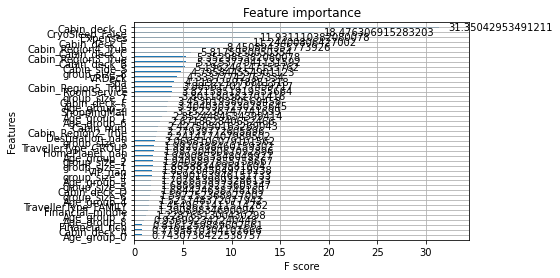

In [ ]:
from numpy import sort 
from sklearn.feature_selection import SelectFromModel

model = xgb.XGBClassifier()
model.fit(X_3, y)
xgb.plot_importance(model, importance_type='gain')
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    if thresh > 0.:
        selection = SelectFromModel(model, threshold=thresh, prefit=True)
        X_selected = selection.transform(X_3).copy()
        xxx = xgb.XGBClassifier()
        xxx.fit(X_selected, y)
        print(get_score(xxx, X_selected, y).mean(), thresh, X_selected.shape[1])
    

In [ ]:
print(X_3)

      ShoppingMall  RoomService       Spa    VRDeck  Expenses  Cabin_num  \
0        -1.002393    -1.002393  7.389564 -1.002393  7.392648         30   
1        -1.002393    -1.002393 -1.002393 -1.002393 -1.002393        761   
2         6.790097     5.075174 -1.002393 -1.002393  6.955593        294   
3         6.684612     0.693147 -1.002393  6.650279  7.390799        436   
4        -1.002393    -1.002393 -1.002393 -1.002393 -1.002393        119   
...            ...          ...       ...       ...       ...        ...   
8688      7.489412    -1.002393  2.944439  6.916715  8.131531         58   
8689      6.171701     5.446737 -1.002393  1.609438  6.573680        543   
8690      0.000000     0.000000  2.708050  6.749931  6.769642       1770   
8691     -1.002393    -1.002393 -1.002393 -1.002393 -1.002393         59   
8692     -1.002393     4.753590  6.590301  3.367296  6.771936        361   

      CryoSleep_False  Cabin_deck_A  Cabin_deck_B  Cabin_deck_C  ...  \
0              

In [97]:
model = xgb.XGBClassifier()
model.fit(X_3, y)
selection = SelectFromModel(model, threshold= 0.008810048, prefit=True)
X_selected = selection.transform(X_3).copy()
test_selected = selection.transform(test_3).copy()
xxx = xgb.XGBClassifier()
xxx.fit(X_selected, y)
#print(get_score(xxx, X_selected, y).mean(), X_selected)


c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
c:\Users\Andrew\anaconda3\envs\Robotics\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [98]:
print(X_selected.shape[1])

34


In [ ]:
perm = PermutationImportance(xgb.XGBClassifier(**params_XGB_best), random_state=1,n_iter =30,cv=8).fit(X, y)
eli5.show_weights(perm, feature_names = X.columns.tolist(),top=50)

KeyboardInterrupt: 

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [91]:
params_XGB_best= {'lambda': 3.6918488316417934, 'alpha': 1.5343679475238137, 'colsample_bytree': 0.9750692030286592, 'subsample': 0.99528646552394, 'learning_rate': 0.08101015405656636, 'n_estimators': 680, 'max_depth': 4, 'min_child_weight': 8}                   
#print(get_score(xgb.XGBClassifier(**params_XGB_best),X_selected,y).mean())
pred_XGB_best = (xgb.XGBClassifier(**params_XGB_best).fit(X_selected,y)).predict(test_selected)
sample = pd.read_csv('./sample_submission.csv')
sample['Transported'] = pred_XGB_best
sample['Transported']=sample['Transported']>0.5
sample.to_csv('311605002.csv', index=False)

In [ ]:
import optuna 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

skf = StratifiedKFold(n_splits=10)
X_selected = pd.DataFrame(X_selected)
def objective(trial, X = X_selected, y = y):
    print("START__________________________________")
    param = {  
        'tree_method':'hist',
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'lambda': trial.suggest_float('lambda', 0, 5.0),
        'alpha': trial.suggest_float('alpha', 0, 5.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7,1.0),
        'subsample': trial.suggest_float('subsample', 0.7,1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001,0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100,1200),
        'max_depth': trial.suggest_categorical('max_depth', [3,4,5,6,7, 8, 9, 10 ]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300)
        #'early_stopping_rounds':200,
        }
    
    results=[]
    n_iterations=[]
    for train_index, test_index in skf.split(X, y):
        train_X, valid_X = X.iloc[train_index], X.iloc[test_index]
        train_y, valid_y = y.iloc[train_index], y.iloc[test_index]
        model = xgb.XGBClassifier(**param).fit(train_X,train_y,
                                      eval_set=[(valid_X,valid_y)],
                                      verbose=0
                                     )  
        #n_iteration = model.get_booster().best_iteration
        #n_iterations.append(n_iteration)
        result = accuracy_score(valid_y,(model.predict(valid_X)))
        results.append(result)
        #i=int(sum(n_iterations)/len(n_iterations))
   # print("Average n_ite=" + str(i))
   # print("% of scatter =" + str(np.std(n_iterations)/i))    
    n=sum(results)/len(results) 
    print (n)
    print("FINISH__________________________________\n")
    return n

optuna_study = "ON"
XGB_study = "ON"
if optuna_study == XGB_study:
    study = optuna.create_study(pruner=optuna.pruners.HyperbandPruner(),
                                direction='maximize')
    study.optimize(objective, n_trials=500)

[I 2023-06-17 19:49:32,157] A new study created in memory with name: no-name-3478f723-ee34-4dc1-a65c-d9f1d16694ce


START__________________________________


[I 2023-06-17 19:49:35,866] Trial 0 finished with value: 0.7823483195111306 and parameters: {'lambda': 2.2479267905371465, 'alpha': 2.2648148183396772, 'colsample_bytree': 0.7494361672326811, 'subsample': 0.772107592276219, 'learning_rate': 0.02143372921902388, 'n_estimators': 278, 'max_depth': 5, 'min_child_weight': 173}. Best is trial 0 with value: 0.7823483195111306.


0.7823483195111306
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:49:49,922] Trial 1 finished with value: 0.8014441225877279 and parameters: {'lambda': 2.755773715401374, 'alpha': 1.2919789369378383, 'colsample_bytree': 0.8829700617848046, 'subsample': 0.8925280993931664, 'learning_rate': 0.07269172479207998, 'n_estimators': 961, 'max_depth': 5, 'min_child_weight': 45}. Best is trial 1 with value: 0.8014441225877279.


0.8014441225877279
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:49:59,142] Trial 2 finished with value: 0.7581901511844767 and parameters: {'lambda': 1.048983646106184, 'alpha': 4.22709509147607, 'colsample_bytree': 0.7652886639128113, 'subsample': 0.8989475215799677, 'learning_rate': 0.0019148227658599872, 'n_estimators': 733, 'max_depth': 10, 'min_child_weight': 250}. Best is trial 1 with value: 0.8014441225877279.


0.7581901511844767
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:50:10,192] Trial 3 finished with value: 0.7717651415949104 and parameters: {'lambda': 3.133694954004258, 'alpha': 2.7772118982668745, 'colsample_bytree': 0.8544009972137989, 'subsample': 0.7323982612392936, 'learning_rate': 0.06216144112063147, 'n_estimators': 1019, 'max_depth': 7, 'min_child_weight': 242}. Best is trial 1 with value: 0.8014441225877279.


0.7717651415949104
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:50:13,343] Trial 4 finished with value: 0.7790126053198947 and parameters: {'lambda': 1.285876177800297, 'alpha': 0.21607869038428484, 'colsample_bytree': 0.8442547625715993, 'subsample': 0.7943135914700025, 'learning_rate': 0.0046868036376643465, 'n_estimators': 169, 'max_depth': 8, 'min_child_weight': 83}. Best is trial 1 with value: 0.8014441225877279.


0.7790126053198947
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:50:17,071] Trial 5 finished with value: 0.7708453368252582 and parameters: {'lambda': 3.0680222890802837, 'alpha': 4.465234760154116, 'colsample_bytree': 0.7949037657928754, 'subsample': 0.8372208014139573, 'learning_rate': 0.09474859922203915, 'n_estimators': 344, 'max_depth': 8, 'min_child_weight': 271}. Best is trial 1 with value: 0.8014441225877279.


0.7708453368252582
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:50:21,998] Trial 6 finished with value: 0.7845334179860586 and parameters: {'lambda': 4.3611425677694164, 'alpha': 2.4085471002412424, 'colsample_bytree': 0.7258212066121787, 'subsample': 0.884181009203819, 'learning_rate': 0.04384639087568523, 'n_estimators': 396, 'max_depth': 7, 'min_child_weight': 209}. Best is trial 1 with value: 0.8014441225877279.


0.7845334179860586
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:50:27,166] Trial 7 finished with value: 0.7836132164067563 and parameters: {'lambda': 0.36831498256827466, 'alpha': 4.7231618179003485, 'colsample_bytree': 0.8142984876272958, 'subsample': 0.742309036977537, 'learning_rate': 0.03546086168621304, 'n_estimators': 411, 'max_depth': 9, 'min_child_weight': 169}. Best is trial 1 with value: 0.8014441225877279.


0.7836132164067563
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:50:31,231] Trial 8 finished with value: 0.795807441503644 and parameters: {'lambda': 3.2665423943297256, 'alpha': 3.6055304948362012, 'colsample_bytree': 0.8918522398739347, 'subsample': 0.8890522484057625, 'learning_rate': 0.08256070167170973, 'n_estimators': 276, 'max_depth': 7, 'min_child_weight': 128}. Best is trial 1 with value: 0.8014441225877279.


0.795807441503644
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:50:34,107] Trial 9 finished with value: 0.7787828525323068 and parameters: {'lambda': 1.5966212350346465, 'alpha': 1.5929882077310487, 'colsample_bytree': 0.8143729646287379, 'subsample': 0.9634708714694913, 'learning_rate': 0.04821962770227408, 'n_estimators': 236, 'max_depth': 9, 'min_child_weight': 266}. Best is trial 1 with value: 0.8014441225877279.


0.7787828525323068
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:50:47,320] Trial 10 finished with value: 0.8100740711347433 and parameters: {'lambda': 4.876729525005802, 'alpha': 0.7043963097451371, 'colsample_bytree': 0.9850146473927538, 'subsample': 0.9883260824328398, 'learning_rate': 0.06860658506970879, 'n_estimators': 1144, 'max_depth': 3, 'min_child_weight': 8}. Best is trial 10 with value: 0.8100740711347433.


0.8100740711347433
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:51:01,006] Trial 11 finished with value: 0.8085790246418794 and parameters: {'lambda': 4.730321568314905, 'alpha': 0.5211023736810336, 'colsample_bytree': 0.9984453599760659, 'subsample': 0.9895261965009914, 'learning_rate': 0.0695025976316884, 'n_estimators': 1195, 'max_depth': 3, 'min_child_weight': 4}. Best is trial 10 with value: 0.8100740711347433.


0.8085790246418794
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:51:13,875] Trial 12 finished with value: 0.8119146065632317 and parameters: {'lambda': 4.914553898162349, 'alpha': 0.11738019465611149, 'colsample_bytree': 0.99618843784344, 'subsample': 0.9944251341208518, 'learning_rate': 0.06577849825753693, 'n_estimators': 1145, 'max_depth': 3, 'min_child_weight': 9}. Best is trial 12 with value: 0.8119146065632317.


0.8119146065632317
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:51:27,644] Trial 13 finished with value: 0.8103048820813988 and parameters: {'lambda': 4.9962585193802695, 'alpha': 0.34537234770810865, 'colsample_bytree': 0.9976659269926994, 'subsample': 0.9995859938638587, 'learning_rate': 0.06116265567129166, 'n_estimators': 1196, 'max_depth': 3, 'min_child_weight': 3}. Best is trial 12 with value: 0.8119146065632317.


0.8103048820813988
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:51:36,524] Trial 14 finished with value: 0.7986832533100539 and parameters: {'lambda': 4.054717717225805, 'alpha': 0.047811447413533825, 'colsample_bytree': 0.9560431871892393, 'subsample': 0.9398940858025995, 'learning_rate': 0.055951874512254085, 'n_estimators': 795, 'max_depth': 3, 'min_child_weight': 73}. Best is trial 12 with value: 0.8119146065632317.


0.7986832533100539
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:51:48,192] Trial 15 finished with value: 0.7948871076544581 and parameters: {'lambda': 3.8944997193638375, 'alpha': 0.904757365705013, 'colsample_bytree': 0.9421972133606316, 'subsample': 0.932017503079428, 'learning_rate': 0.08167941409611851, 'n_estimators': 932, 'max_depth': 4, 'min_child_weight': 113}. Best is trial 12 with value: 0.8119146065632317.


0.7948871076544581
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:51:57,827] Trial 16 finished with value: 0.8016734785656652 and parameters: {'lambda': 4.894178659416062, 'alpha': 0.22072042953802917, 'colsample_bytree': 0.9371632511122819, 'subsample': 0.988331011641025, 'learning_rate': 0.055769774242141294, 'n_estimators': 599, 'max_depth': 6, 'min_child_weight': 55}. Best is trial 12 with value: 0.8119146065632317.


0.8016734785656652
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:52:09,901] Trial 17 finished with value: 0.8048955729270004 and parameters: {'lambda': 3.6724426015411797, 'alpha': 1.142327728747727, 'colsample_bytree': 0.974834408192083, 'subsample': 0.9496399012674112, 'learning_rate': 0.03939650170386444, 'n_estimators': 1070, 'max_depth': 3, 'min_child_weight': 26}. Best is trial 12 with value: 0.8119146065632317.


0.8048955729270004
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:52:19,431] Trial 18 finished with value: 0.795807706043411 and parameters: {'lambda': 4.347602096872798, 'alpha': 1.6687262129650937, 'colsample_bytree': 0.91153179571367, 'subsample': 0.9988587224270911, 'learning_rate': 0.057870058974954966, 'n_estimators': 834, 'max_depth': 3, 'min_child_weight': 94}. Best is trial 12 with value: 0.8119146065632317.


0.795807706043411
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:52:32,365] Trial 19 finished with value: 0.8028246233615068 and parameters: {'lambda': 4.960270743088354, 'alpha': 0.011604291450681037, 'colsample_bytree': 0.9923538907703772, 'subsample': 0.9643771817273601, 'learning_rate': 0.09804468250649195, 'n_estimators': 640, 'max_depth': 10, 'min_child_weight': 44}. Best is trial 12 with value: 0.8119146065632317.


0.8028246233615068
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:52:39,573] Trial 20 finished with value: 0.7964981548351255 and parameters: {'lambda': 3.6105919833281854, 'alpha': 0.6361628801034784, 'colsample_bytree': 0.9616359619516441, 'subsample': 0.9236805009107968, 'learning_rate': 0.04873315556349988, 'n_estimators': 512, 'max_depth': 6, 'min_child_weight': 137}. Best is trial 12 with value: 0.8119146065632317.


0.7964981548351255
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:52:53,346] Trial 21 finished with value: 0.8107649167361084 and parameters: {'lambda': 4.537630418221626, 'alpha': 0.7398357707719718, 'colsample_bytree': 0.9974713216080902, 'subsample': 0.9972742567408394, 'learning_rate': 0.0683111765899746, 'n_estimators': 1192, 'max_depth': 3, 'min_child_weight': 4}. Best is trial 12 with value: 0.8119146065632317.


0.8107649167361084
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:53:05,999] Trial 22 finished with value: 0.8071970688993824 and parameters: {'lambda': 4.387578053293243, 'alpha': 0.5969722158067313, 'colsample_bytree': 0.9695403883478818, 'subsample': 0.9668457812955056, 'learning_rate': 0.06529698813332249, 'n_estimators': 1107, 'max_depth': 3, 'min_child_weight': 22}. Best is trial 12 with value: 0.8119146065632317.


0.8071970688993824
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:53:20,169] Trial 23 finished with value: 0.8098436569977382 and parameters: {'lambda': 4.491087031896985, 'alpha': 1.0237094213200622, 'colsample_bytree': 0.9978672326107713, 'subsample': 0.9977345420162481, 'learning_rate': 0.08046757937553929, 'n_estimators': 1194, 'max_depth': 3, 'min_child_weight': 1}. Best is trial 12 with value: 0.8119146065632317.


0.8098436569977382
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:53:31,934] Trial 24 finished with value: 0.8007542028755472 and parameters: {'lambda': 4.008566807501744, 'alpha': 0.39885530018352167, 'colsample_bytree': 0.931296340813677, 'subsample': 0.9695347346234982, 'learning_rate': 0.07507026921454435, 'n_estimators': 911, 'max_depth': 4, 'min_child_weight': 52}. Best is trial 12 with value: 0.8119146065632317.


0.8007542028755472
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:53:44,100] Trial 25 finished with value: 0.803285716175284 and parameters: {'lambda': 4.952407083561893, 'alpha': 0.017651024879055427, 'colsample_bytree': 0.9604424131282497, 'subsample': 0.9284743387396884, 'learning_rate': 0.06215090922269574, 'n_estimators': 1041, 'max_depth': 3, 'min_child_weight': 29}. Best is trial 12 with value: 0.8119146065632317.


0.803285716175284
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:53:58,018] Trial 26 finished with value: 0.7996035871592397 and parameters: {'lambda': 4.550273119791319, 'alpha': 0.8317990235930581, 'colsample_bytree': 0.9737807430273164, 'subsample': 0.9540691574707413, 'learning_rate': 0.05558904947390466, 'n_estimators': 1113, 'max_depth': 3, 'min_child_weight': 68}. Best is trial 12 with value: 0.8119146065632317.


0.7996035871592397
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:54:09,294] Trial 27 finished with value: 0.7954615557583695 and parameters: {'lambda': 4.165318486213713, 'alpha': 0.36609738520958224, 'colsample_bytree': 0.93106220065736, 'subsample': 0.9812846791995868, 'learning_rate': 0.07607654419785577, 'n_estimators': 1002, 'max_depth': 3, 'min_child_weight': 106}. Best is trial 12 with value: 0.8119146065632317.


0.7954615557583695
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:54:19,173] Trial 28 finished with value: 0.8044360673518248 and parameters: {'lambda': 4.623876900367588, 'alpha': 1.4112750633118258, 'colsample_bytree': 0.9975268808874206, 'subsample': 0.9149576397751413, 'learning_rate': 0.06546368417804684, 'n_estimators': 859, 'max_depth': 3, 'min_child_weight': 30}. Best is trial 12 with value: 0.8119146065632317.


0.8044360673518248
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:54:32,387] Trial 29 finished with value: 0.7886754493869292 and parameters: {'lambda': 3.6827415757445783, 'alpha': 2.051688112581581, 'colsample_bytree': 0.9785173086292368, 'subsample': 0.9457240780749413, 'learning_rate': 0.0889405641677992, 'n_estimators': 1150, 'max_depth': 5, 'min_child_weight': 202}. Best is trial 12 with value: 0.8119146065632317.


0.7886754493869292
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:54:45,874] Trial 30 finished with value: 0.800179490231869 and parameters: {'lambda': 4.998113871952667, 'alpha': 1.0580146906546095, 'colsample_bytree': 0.9505981538440946, 'subsample': 0.9671969955838196, 'learning_rate': 0.03384697359717406, 'n_estimators': 743, 'max_depth': 8, 'min_child_weight': 57}. Best is trial 12 with value: 0.8119146065632317.


0.800179490231869
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:54:58,668] Trial 31 finished with value: 0.8069675806515614 and parameters: {'lambda': 4.76381606280626, 'alpha': 0.7948115087219423, 'colsample_bytree': 0.9766305600456938, 'subsample': 0.9870996566379109, 'learning_rate': 0.06901555749318757, 'n_estimators': 1134, 'max_depth': 3, 'min_child_weight': 14}. Best is trial 12 with value: 0.8119146065632317.


0.8069675806515614
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:55:12,462] Trial 32 finished with value: 0.8099588640662407 and parameters: {'lambda': 4.636026656879065, 'alpha': 0.5384260800306555, 'colsample_bytree': 0.9836569840853894, 'subsample': 0.9991863310933555, 'learning_rate': 0.07144132927596065, 'n_estimators': 1194, 'max_depth': 3, 'min_child_weight': 2}. Best is trial 12 with value: 0.8119146065632317.


0.8099588640662407
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:55:27,466] Trial 33 finished with value: 0.8044355382722909 and parameters: {'lambda': 4.172787137650528, 'alpha': 0.6945696040566907, 'colsample_bytree': 0.9991270893755237, 'subsample': 0.9810911883842259, 'learning_rate': 0.0749499560289103, 'n_estimators': 984, 'max_depth': 5, 'min_child_weight': 38}. Best is trial 12 with value: 0.8119146065632317.


0.8044355382722909
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:55:51,429] Trial 34 finished with value: 0.8053565334708941 and parameters: {'lambda': 2.566970921790349, 'alpha': 1.275913748162976, 'colsample_bytree': 0.9150446229293706, 'subsample': 0.9473780396565524, 'learning_rate': 0.06455628074087721, 'n_estimators': 1073, 'max_depth': 10, 'min_child_weight': 17}. Best is trial 12 with value: 0.8119146065632317.


0.8053565334708941
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:56:02,354] Trial 35 finished with value: 0.7769416557544013 and parameters: {'lambda': 4.622149731502884, 'alpha': 0.32764665431552364, 'colsample_bytree': 0.9564112164786505, 'subsample': 0.9781483951014207, 'learning_rate': 0.05982652856726356, 'n_estimators': 1044, 'max_depth': 3, 'min_child_weight': 296}. Best is trial 12 with value: 0.8119146065632317.


0.7769416557544013
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:56:17,789] Trial 36 finished with value: 0.79822229276616 and parameters: {'lambda': 4.305647845552968, 'alpha': 0.8740319798188043, 'colsample_bytree': 0.9720515519439906, 'subsample': 0.9116118234787354, 'learning_rate': 0.05268459796356986, 'n_estimators': 946, 'max_depth': 9, 'min_child_weight': 79}. Best is trial 12 with value: 0.8119146065632317.


0.79822229276616
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:56:35,573] Trial 37 finished with value: 0.8037464121794109 and parameters: {'lambda': 4.977629869160655, 'alpha': 0.2884341948196931, 'colsample_bytree': 0.9807181859208612, 'subsample': 0.9555326891550171, 'learning_rate': 0.06816367116682401, 'n_estimators': 1141, 'max_depth': 6, 'min_child_weight': 42}. Best is trial 12 with value: 0.8119146065632317.


0.8037464121794109
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:56:37,383] Trial 38 finished with value: 0.7999472243164953 and parameters: {'lambda': 4.676084913575253, 'alpha': 1.140670930203505, 'colsample_bytree': 0.9438055067867915, 'subsample': 0.9764334108398874, 'learning_rate': 0.06085404441551773, 'n_estimators': 118, 'max_depth': 4, 'min_child_weight': 17}. Best is trial 12 with value: 0.8119146065632317.


0.7999472243164953
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:56:51,785] Trial 39 finished with value: 0.7966124360144439 and parameters: {'lambda': 4.353945220817782, 'alpha': 0.592857717784188, 'colsample_bytree': 0.9865526961823493, 'subsample': 0.8638746560333624, 'learning_rate': 0.07221087807230074, 'n_estimators': 894, 'max_depth': 7, 'min_child_weight': 64}. Best is trial 12 with value: 0.8119146065632317.


0.7966124360144439
FINISH__________________________________

START__________________________________


[I 2023-06-17 19:57:04,345] Trial 40 finished with value: 0.7922410486356362 and parameters: {'lambda': 3.900914065244133, 'alpha': 1.89597057712474, 'colsample_bytree': 0.8724701904652525, 'subsample': 0.9365764751438819, 'learning_rate': 0.051935275452024435, 'n_estimators': 996, 'max_depth': 8, 'min_child_weight': 175}. Best is trial 12 with value: 0.8119146065632317.


0.7922410486356362
FINISH__________________________________

START__________________________________
